In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error,median_absolute_error,r2_score

In [3]:
df = pd.read_csv("cpu_mem_req_lat_211022_190123.csv")
df.head(5)

,Date,Process CPU usage,Process memory usage,Request count,Reponse time
0,2022-10-21 12:00,3.83,6.26,316000.0,0.198
1,2022-10-21 13:00,5.01,6.27,436000.0,0.252
2,2022-10-21 14:00,4.38,6.29,376000.0,0.230
3,2022-10-21 15:00,4.34,6.29,378000.0,0.200
4,2022-10-21 16:00,3.77,6.30,312000.0,0.191


In [4]:
df.dropna(inplace=True)
df.columns = ['timestamp', 'cpu', 'memory', 'request', 'latency']
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M'))
df

,timestamp,cpu,memory,request,latency
0,2022-10-21 12:00:00,3.83,6.26,316000.0,0.198
1,2022-10-21 13:00:00,5.01,6.27,436000.0,0.252
2,2022-10-21 14:00:00,4.38,6.29,376000.0,0.230
3,2022-10-21 15:00:00,4.34,6.29,378000.0,0.200
4,2022-10-21 16:00:00,3.77,6.30,312000.0,0.191
...,...,...,...,...,...
2156,2023-01-19 08:00:00,1.27,3.26,204000.0,0.157
2157,2023-01-19 09:00:00,1.35,3.26,211000.0,0.153
2158,2023-01-19 10:00:00,1.44,3.27,235000.0,0.141
2159,2023-01-19 11:00:00,2.23,3.27,644000.0,0.104


In [5]:
#separates 80% of this data
training_data_len = math.floor(len(df)*.8)

##CPU

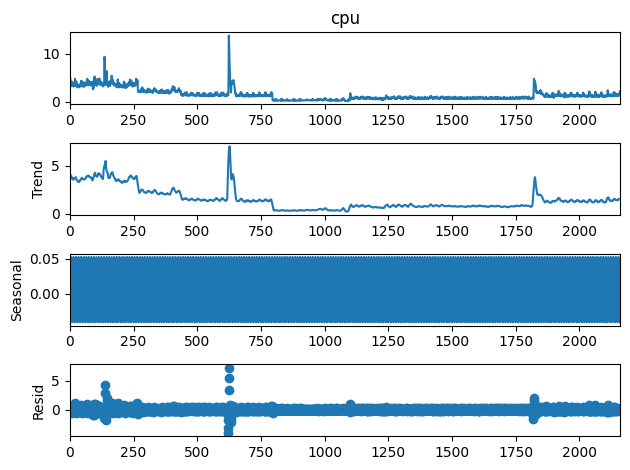

In [6]:
decompose = seasonal_decompose(df['cpu'], model='additive', period=10)
decompose.plot()
plt.show()

In [7]:
start_cpu = time.time()

In [8]:
##CPU
#creating a training dataset
train_cpu = pd.DataFrame(df[0:training_data_len]['timestamp'])
train_cpu['cpu'] = df[0:training_data_len]['cpu']
train_cpu.set_index('timestamp',inplace = True)

#creating the test base
test_cpu = pd.DataFrame(df[training_data_len+1:]['timestamp'])
test_cpu['cpu'] = df[training_data_len+1:]['cpu']
test_cpu.set_index('timestamp',inplace = True)

Text(0, 0.5, 'Value')

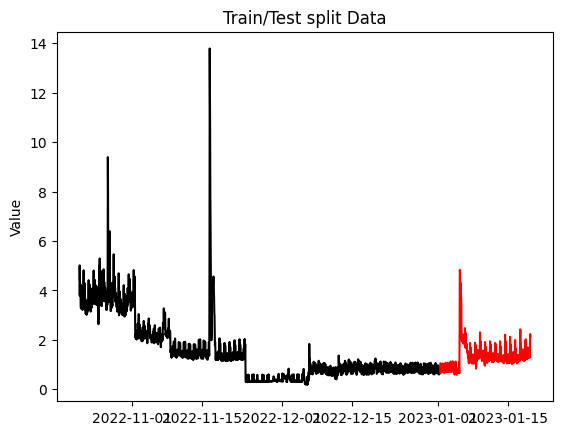

In [9]:
plt.plot(train_cpu, color = "black")
plt.plot(test_cpu, color = "red")
plt.title("Train/Test split Data")
plt.ylabel("Value")

In [10]:
model_cpu = auto_arima(train_cpu, 
                   start_P=1, 
                       start_q=1, 
                       max_p=3, 
                       max_q=3, 
                       m=10, 
                       sazonal=True, 
                       d=None, 
                       D=1, 
                       trace=True, 
                       error_action='ignore', 
                       suppress_warnings=True, 
                       stepwise=True)

model_cpu.fit(train_cpu)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[10] intercept   : AIC=inf, Time=14.53 sec
 ARIMA(0,0,0)(0,1,0)[10] intercept   : AIC=4202.025, Time=0.55 sec
 ARIMA(1,0,0)(1,1,0)[10] intercept   : AIC=2268.110, Time=3.14 sec
 ARIMA(0,0,1)(0,1,1)[10] intercept   : AIC=2422.631, Time=5.75 sec
 ARIMA(0,0,0)(0,1,0)[10]             : AIC=4200.977, Time=0.20 sec
 ARIMA(1,0,0)(0,1,0)[10] intercept   : AIC=2833.168, Time=1.14 sec
 ARIMA(1,0,0)(2,1,0)[10] intercept   : AIC=2110.513, Time=5.28 sec
 ARIMA(1,0,0)(2,1,1)[10] intercept   : AIC=inf, Time=14.92 sec
 ARIMA(1,0,0)(1,1,1)[10] intercept   : AIC=inf, Time=5.27 sec
 ARIMA(0,0,0)(2,1,0)[10] intercept   : AIC=3759.843, Time=2.41 sec
 ARIMA(2,0,0)(2,1,0)[10] intercept   : AIC=2092.998, Time=5.62 sec
 ARIMA(2,0,0)(1,1,0)[10] intercept   : AIC=2247.149, Time=2.57 sec
 ARIMA(2,0,0)(2,1,1)[10] intercept   : AIC=inf, Time=17.39 sec
 ARIMA(2,0,0)(1,1,1)[10] intercept   : AIC=inf, Time=7.66 sec
 ARIMA(3,0,0)(2,1,0)[10] intercept   : AI

ARIMA(order=(2, 0, 3), scoring_args={}, seasonal_order=(2, 1, 0, 10),
      suppress_warnings=True, with_intercept=False)

In [11]:
predictions_cpu = model_cpu.predict(n_periods = len(test_cpu))
predictions_cpu = pd.DataFrame(predictions_cpu, index = test_cpu.index, columns=['cpu'])
predictions_cpu = predictions_cpu.fillna(0)
predictions_cpu

,cpu
timestamp,
2023-01-01 13:00:00,0.753609
2023-01-01 14:00:00,0.730562
2023-01-01 15:00:00,0.727885
2023-01-01 16:00:00,0.740195
2023-01-01 17:00:00,0.786175
...,...
2023-01-19 08:00:00,0.839662
2023-01-19 09:00:00,0.822855
2023-01-19 10:00:00,0.755505


In [12]:
end_cpu = time.time()

Text(0, 0.5, 'Value')

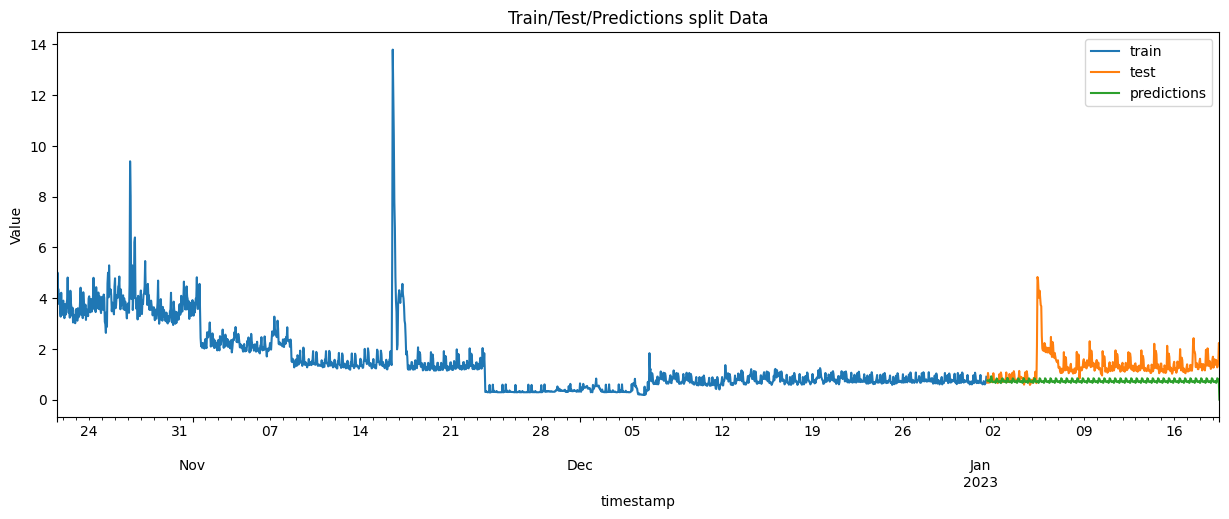

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
train_cpu['cpu'].plot(ax=ax, label='train')
test_cpu['cpu'].plot(ax=ax, label='test')
predictions_cpu['cpu'].plot(ax=ax, label='predictions')
ax.legend()
plt.title("Train/Test/Predictions split Data")
plt.ylabel("Value")

In [14]:
print('Erro médio absoluto :', mean_absolute_error(predictions_cpu['cpu'], test_cpu['cpu']))
print('Erro médio quadrado :', mean_squared_error(predictions_cpu['cpu'], test_cpu['cpu']))
print('Coeficiente de determinação (R²):', r2_score(predictions_cpu['cpu'], test_cpu['cpu']))
print("Tempo de execução:", end_cpu-start_cpu)

Erro médio absoluto : 0.5954570785470004
Erro médio quadrado : 0.642253919093139
Coeficiente de determinação (R²): -146.8351891052105
Tempo de execução: 481.8784410953522


##Memory

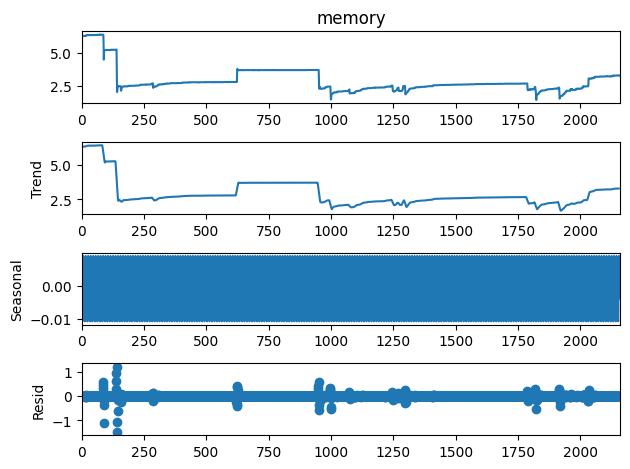

In [15]:
decompose = seasonal_decompose(df['memory'], model='additive', period=10)
decompose.plot()
plt.show()

In [16]:
start_memory = time.time()

In [17]:
##Memory
#creating a training dataset
train_memory = pd.DataFrame(df[0:training_data_len]['timestamp'])
train_memory['memory'] = df[0:training_data_len]['memory']
train_memory.set_index('timestamp',inplace = True)

#creating the test base
test_memory = pd.DataFrame(df[training_data_len+1:]['timestamp'])
test_memory['memory'] = df[training_data_len+1:]['memory']
test_memory.set_index('timestamp',inplace = True)

Text(0, 0.5, 'Value')

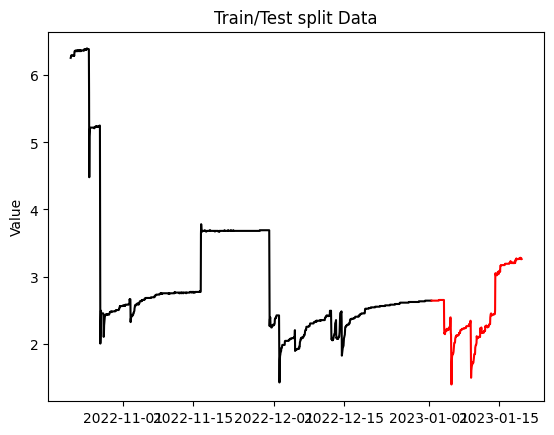

In [18]:
plt.plot(train_memory, color = "black")
plt.plot(test_memory, color = "red")
plt.title("Train/Test split Data")
plt.ylabel("Value")

In [19]:
model_memory = auto_arima(train_memory, 
                   start_P=1, 
                       start_q=1, 
                       max_p=3, 
                       max_q=3, 
                       m=10, 
                       sazonal=True, 
                       d=None, 
                       D=1, 
                       trace=True, 
                       error_action='ignore', 
                       suppress_warnings=True, 
                       stepwise=True)

model_memory.fit(train_memory)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[10] intercept   : AIC=inf, Time=11.64 sec
 ARIMA(0,0,0)(0,1,0)[10] intercept   : AIC=526.511, Time=0.25 sec
 ARIMA(1,0,0)(1,1,0)[10] intercept   : AIC=-3082.719, Time=3.50 sec
 ARIMA(0,0,1)(0,1,1)[10] intercept   : AIC=inf, Time=6.21 sec
 ARIMA(0,0,0)(0,1,0)[10]             : AIC=534.260, Time=0.16 sec
 ARIMA(1,0,0)(0,1,0)[10] intercept   : AIC=-2624.212, Time=0.21 sec
 ARIMA(1,0,0)(2,1,0)[10] intercept   : AIC=-3274.755, Time=14.47 sec
 ARIMA(1,0,0)(2,1,1)[10] intercept   : AIC=inf, Time=17.94 sec
 ARIMA(1,0,0)(1,1,1)[10] intercept   : AIC=inf, Time=8.58 sec
 ARIMA(0,0,0)(2,1,0)[10] intercept   : AIC=526.671, Time=2.24 sec
 ARIMA(2,0,0)(2,1,0)[10] intercept   : AIC=-3479.844, Time=12.54 sec
 ARIMA(2,0,0)(1,1,0)[10] intercept   : AIC=-3308.515, Time=6.58 sec
 ARIMA(2,0,0)(2,1,1)[10] intercept   : AIC=inf, Time=23.12 sec
 ARIMA(2,0,0)(1,1,1)[10] intercept   : AIC=inf, Time=10.85 sec
 ARIMA(3,0,0)(2,1,0)[10] intercept   : AI

ARIMA(order=(3, 0, 1), scoring_args={}, seasonal_order=(2, 1, 0, 10),
      suppress_warnings=True, with_intercept=False)

In [20]:
predictions_memory = model_memory.predict(n_periods = len(test_memory))
predictions_memory = pd.DataFrame(predictions_memory, index = test_memory.index, columns=['memory'])
predictions_memory = predictions_memory.fillna(0)
predictions_memory

,memory
timestamp,
2023-01-01 13:00:00,2.642875
2023-01-01 14:00:00,2.642708
2023-01-01 15:00:00,2.642557
2023-01-01 16:00:00,2.642415
2023-01-01 17:00:00,2.642280
...,...
2023-01-19 08:00:00,2.642231
2023-01-19 09:00:00,2.642106
2023-01-19 10:00:00,2.643544


In [21]:
end_memory = time.time()

Text(0, 0.5, 'Value')

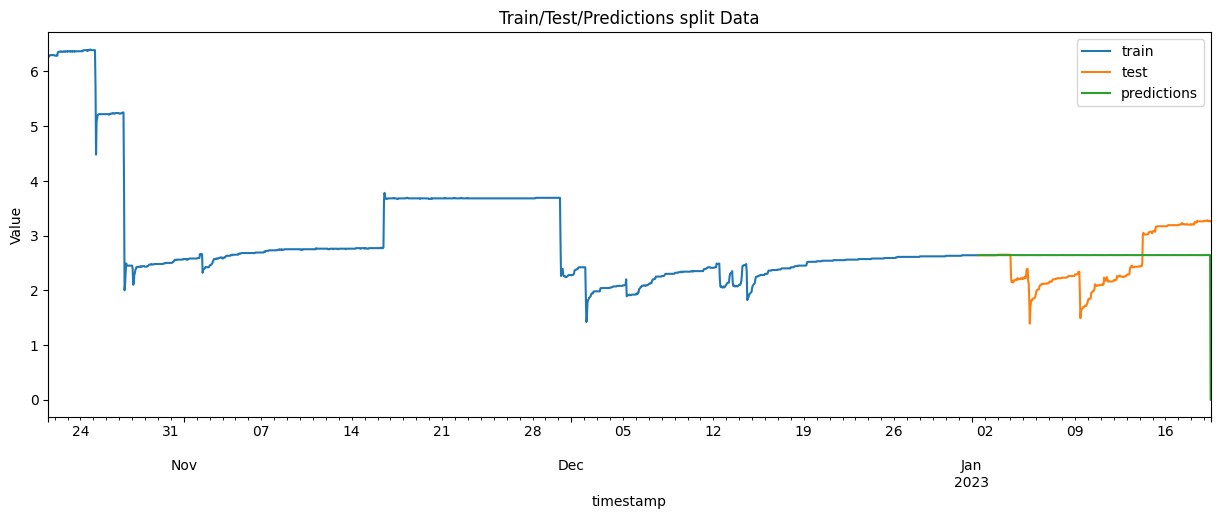

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))
train_memory['memory'].plot(ax=ax, label='train')
test_memory['memory'].plot(ax=ax, label='test')
predictions_memory['memory'].plot(ax=ax, label='predictions')
ax.legend()
plt.title("Train/Test/Predictions split Data")
plt.ylabel("Value")

In [23]:
print('Erro médio absoluto :', mean_absolute_error(predictions_memory['memory'], test_memory['memory']))
print('Erro médio quadrado :', mean_squared_error(predictions_memory['memory'], test_memory['memory']))
print('Coeficiente de determinação (R²):', r2_score(predictions_memory['memory'], test_memory['memory']))
print("Tempo de execução:", end_memory-start_memory)

Erro médio absoluto : 0.44335181622519876
Erro médio quadrado : 0.2681895672329741
Coeficiente de determinação (R²): -15.62727808279234
Tempo de execução: 434.90519285202026


##Request

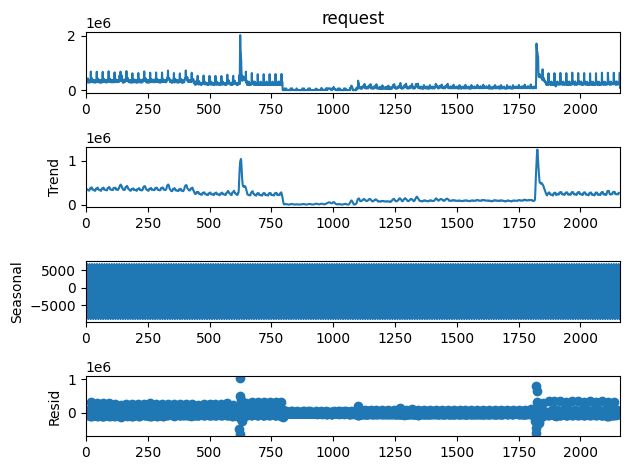

In [24]:
decompose = seasonal_decompose(df['request'], model='additive', period=10)
decompose.plot()
plt.show()

In [25]:
start_request = time.time()

In [26]:
##Request
#creating a training dataset
train_request = pd.DataFrame(df[0:training_data_len]['timestamp'])
train_request['request'] = df[0:training_data_len]['request']
train_request.set_index('timestamp',inplace = True)

#creating the test base
test_request = pd.DataFrame(df[training_data_len+1:]['timestamp'])
test_request['request'] = df[training_data_len+1:]['request']
test_request.set_index('timestamp',inplace = True)

Text(0, 0.5, 'Value')

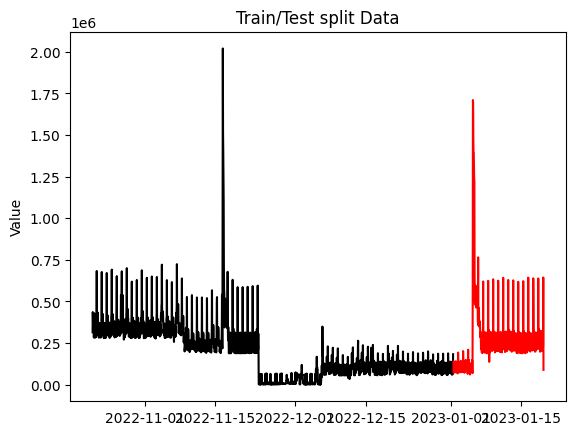

In [27]:
plt.plot(train_request, color = "black")
plt.plot(test_request, color = "red")
plt.title("Train/Test split Data")
plt.ylabel("Value")

In [28]:
model_request = auto_arima(train_request, 
                   start_P=1, 
                       start_q=1, 
                       max_p=3, 
                       max_q=3, 
                       m=10, 
                       sazonal=True, 
                       d=None, 
                       D=1, 
                       trace=True, 
                       error_action='ignore', 
                       suppress_warnings=True, 
                       stepwise=True)
model_request.fit(train_request)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[10] intercept   : AIC=inf, Time=7.18 sec
 ARIMA(0,0,0)(0,1,0)[10] intercept   : AIC=45475.366, Time=0.21 sec
 ARIMA(1,0,0)(1,1,0)[10] intercept   : AIC=44208.841, Time=0.83 sec
 ARIMA(0,0,1)(0,1,1)[10] intercept   : AIC=44175.626, Time=1.40 sec
 ARIMA(0,0,0)(0,1,0)[10]             : AIC=45473.625, Time=0.10 sec
 ARIMA(0,0,1)(0,1,0)[10] intercept   : AIC=44835.487, Time=0.56 sec
 ARIMA(0,0,1)(1,1,1)[10] intercept   : AIC=44176.166, Time=1.92 sec
 ARIMA(0,0,1)(0,1,2)[10] intercept   : AIC=44176.250, Time=2.53 sec
 ARIMA(0,0,1)(1,1,0)[10] intercept   : AIC=44402.269, Time=0.69 sec
 ARIMA(0,0,1)(1,1,2)[10] intercept   : AIC=44177.559, Time=5.77 sec
 ARIMA(0,0,0)(0,1,1)[10] intercept   : AIC=44827.695, Time=1.06 sec
 ARIMA(1,0,1)(0,1,1)[10] intercept   : AIC=inf, Time=2.70 sec
 ARIMA(0,0,2)(0,1,1)[10] intercept   : AIC=44087.256, Time=1.75 sec
 ARIMA(0,0,2)(0,1,0)[10] intercept   : AIC=44774.079, Time=0.49 sec
 ARIMA(0,0,2)(1,1

ARIMA(order=(0, 0, 3), scoring_args={}, seasonal_order=(2, 1, 1, 10),
      suppress_warnings=True, with_intercept=False)

In [29]:
predictions_request = model_request.predict(n_periods = len(test_request))
predictions_request = pd.DataFrame(predictions_request, index = test_request.index, columns=['request'])
predictions_request = predictions_request.fillna(0)
predictions_request

,request
timestamp,
2023-01-01 13:00:00,121499.741399
2023-01-01 14:00:00,108946.848356
2023-01-01 15:00:00,88785.761744
2023-01-01 16:00:00,87668.083995
2023-01-01 17:00:00,97915.678805
...,...
2023-01-19 08:00:00,92578.584761
2023-01-19 09:00:00,101250.205476
2023-01-19 10:00:00,93400.120392


In [30]:
end_request = time.time()

Text(0, 0.5, 'Value')

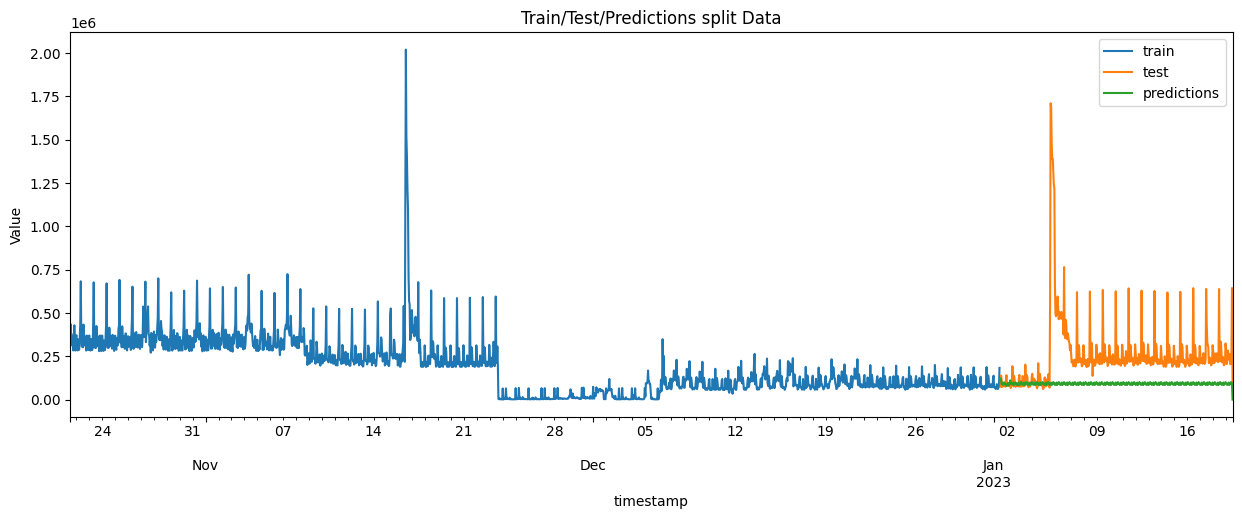

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
train_request['request'].plot(ax=ax, label='train')
test_request['request'].plot(ax=ax, label='test')
predictions_request['request'].plot(ax=ax, label='predictions')
ax.legend()
plt.title("Train/Test/Predictions split Data")
plt.ylabel("Value")

In [32]:
print('Erro médio absoluto :', mean_absolute_error(predictions_request['request'], test_request['request']))
print('Erro médio quadrado :', mean_squared_error(predictions_request['request'], test_request['request']))
print('Coeficiente de determinação (R²):', r2_score(predictions_request['request'], test_request['request']))
print("Tempo de execução:", end_request-start_request)

Erro médio absoluto : 167754.52900959566
Erro médio quadrado : 67675058486.45258
Coeficiente de determinação (R²): -1292.327748975718
Tempo de execução: 209.65118384361267


##Latency

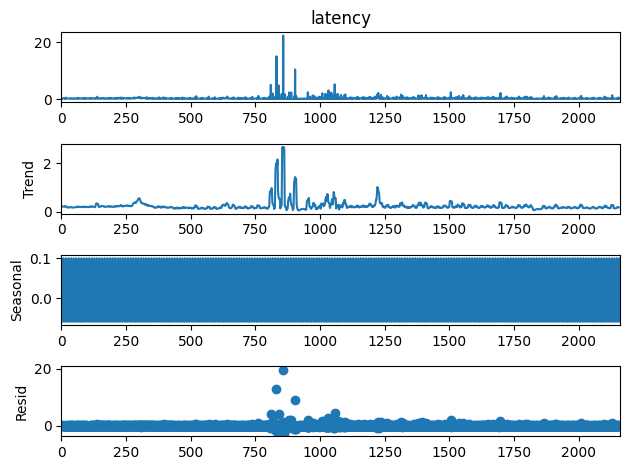

In [33]:
decompose = seasonal_decompose(df['latency'], model='additive', period=10)
decompose.plot()
plt.show()

In [34]:
start_latency = time.time()

In [35]:
##Latency
#creating a training dataset
train_latency = pd.DataFrame(df[0:training_data_len]['timestamp'])
train_latency['latency'] = df[0:training_data_len]['latency']
train_latency.set_index('timestamp',inplace = True)

#creating the test base
test_latency = pd.DataFrame(df[training_data_len+1:]['timestamp'])
test_latency['latency'] = df[training_data_len+1:]['latency']
test_latency.set_index('timestamp',inplace = True)

Text(0, 0.5, 'Value')

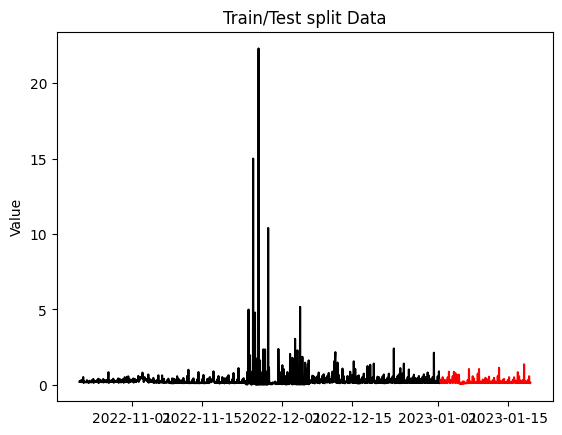

In [36]:
plt.plot(train_latency, color = "black")
plt.plot(test_latency, color = "red")
plt.title("Train/Test split Data")
plt.ylabel("Value")

In [37]:
model_latency = auto_arima(train_latency, 
                   start_P=1, 
                       start_q=1, 
                       max_p=3, 
                       max_q=3, 
                       m=10, 
                       sazonal=True, 
                       d=None, 
                       D=1, 
                       trace=True, 
                       error_action='ignore', 
                       suppress_warnings=True, 
                       stepwise=True)
model_latency.fit(train_latency)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[10] intercept   : AIC=inf, Time=10.00 sec
 ARIMA(0,0,0)(0,1,0)[10] intercept   : AIC=5196.527, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[10] intercept   : AIC=4656.241, Time=1.11 sec
 ARIMA(0,0,1)(0,1,1)[10] intercept   : AIC=inf, Time=6.34 sec
 ARIMA(0,0,0)(0,1,0)[10]             : AIC=5194.527, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[10] intercept   : AIC=5198.054, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[10] intercept   : AIC=4445.217, Time=4.10 sec
 ARIMA(1,0,0)(2,1,1)[10] intercept   : AIC=inf, Time=17.10 sec
 ARIMA(1,0,0)(1,1,1)[10] intercept   : AIC=inf, Time=9.43 sec
 ARIMA(0,0,0)(2,1,0)[10] intercept   : AIC=4444.763, Time=2.28 sec
 ARIMA(0,0,0)(1,1,0)[10] intercept   : AIC=4657.504, Time=0.81 sec
 ARIMA(0,0,0)(2,1,1)[10] intercept   : AIC=inf, Time=12.48 sec
 ARIMA(0,0,0)(1,1,1)[10] intercept   : AIC=inf, Time=6.61 sec
 ARIMA(0,0,1)(2,1,0)[10] intercept   : AIC=4445.294, Time=2.67 sec
 ARIMA(1,0,1)(2,1,0)[10] intercept   : AIC=444

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(2, 1, 0, 10),
      suppress_warnings=True, with_intercept=False)

In [38]:
predictions_latency = model_latency.predict(n_periods = len(test_latency))
predictions_latency = pd.DataFrame(predictions_latency, index = test_latency.index, columns=['latency'])
predictions_latency = predictions_latency.fillna(0)
predictions_latency

,latency
timestamp,
2023-01-01 13:00:00,0.156266
2023-01-01 14:00:00,0.167951
2023-01-01 15:00:00,0.190883
2023-01-01 16:00:00,0.370543
2023-01-01 17:00:00,0.151732
...,...
2023-01-19 08:00:00,0.287975
2023-01-19 09:00:00,0.141837
2023-01-19 10:00:00,0.477296


In [39]:
end_latency = time.time()

Text(0, 0.5, 'Value')

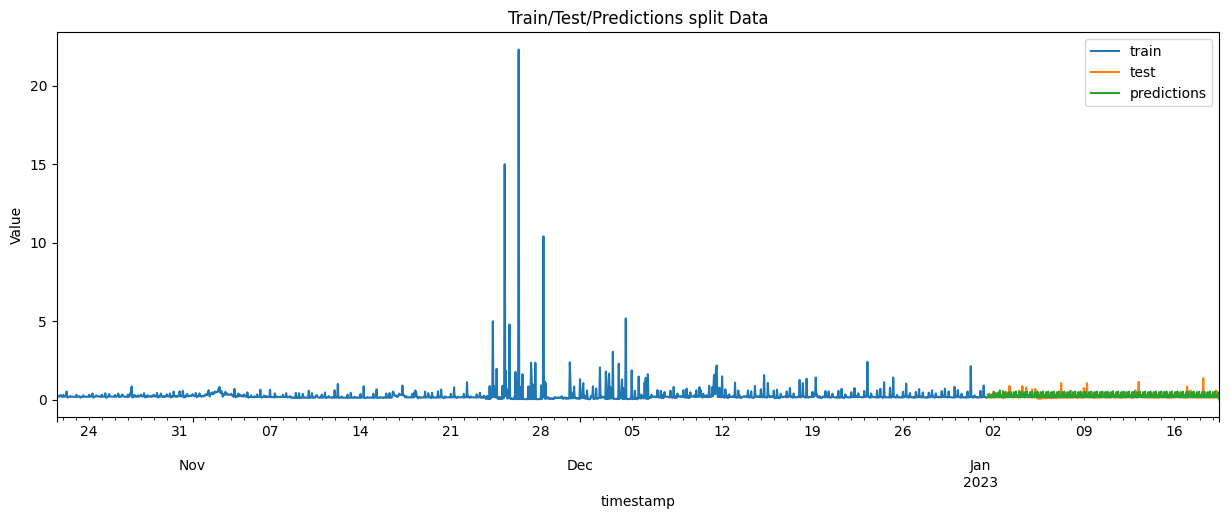

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))
train_latency['latency'].plot(ax=ax, label='train')
test_latency['latency'].plot(ax=ax, label='test')
predictions_latency['latency'].plot(ax=ax, label='predictions')
ax.legend()
plt.title("Train/Test/Predictions split Data")
plt.ylabel("Value")

In [41]:
print('Erro médio absoluto :', mean_absolute_error(predictions_latency['latency'], test_latency['latency']))
print('Erro médio quadrado :', mean_squared_error(predictions_latency['latency'], test_latency['latency']))
print('Coeficiente de determinação (R²):', r2_score(predictions_latency['latency'], test_latency['latency']))
print("Tempo de execução:", end_latency-start_latency)

Erro médio absoluto : 0.11971009810792396
Erro médio quadrado : 0.039658012520229574
Coeficiente de determinação (R²): -1.3177970524996665
Tempo de execução: 101.95753216743469
